# Study Case: BBC News, Correlation Analysis

In this python notebook it will be studied a BBC news dataset and analyzed with DimCuantifier to estimate complexity of all news. For now on news will be treated as documents, and the number of dimensions estimated with DimCunatifier will be called complexity. 

The focus of interest in this notebook is correlation between complexity and lenght of documents and how to smooth out any possible issue

In [2]:
# Import
from DimCuantifier import DimCuantifier
from PreProcessingDimCuantifier import PreProcessingDimCuantifier
from IPython.display import display

import gensim
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import random

## Set Model

First, set word embeddings model, in this case normalized Glove with 42 billions of words and 300 dimensions

In [2]:
# normalized glove embeddings
norm_glove_42B = 'normalized_glove.42B.300d.mod'

current_model = gensim.models.KeyedVectors.load_word2vec_format(
    norm_glove_42B, binary=True)

## Set Polar Words list

Set list of pairs of polar words to use as semantic axis (list of words obtained from Polar framework repository) 

In [3]:
PreProcess = PreProcessingDimCuantifier()

In [4]:
filenames_list = ['..\Antonym_sets\LenciBenotto.val',
                  '..\Antonym_sets\LenciBenotto.test',
                  '..\Antonym_sets\EVALution.val',
                  '..\Antonym_sets\EVALution.test']

# Extract polar pairs from files
list_polar_pairs = PreProcess.list_polar_words_tuple(
    filenames_list, current_model)

# Select most different polar pairs when there is repetition of words
final_polar_pairs_list = PreProcess.select_polar_words_list(
    current_model, list_polar_pairs)

# Print a sample of final polar pairs
final_polar_pairs_list[0:5]

[('exclude', 'inscribe'),
 ('assertion', 'meek'),
 ('beginning', 'terminal'),
 ('lop', 'secure'),
 ('libertine', 'pastor')]

## Load Dataset

Load dataset already tokenized in pickle format

In [5]:
filename = 'bbc_news_dataset_tokenized.pkl'
bbc_news_dataset = pd.read_pickle(filename)
bbc_news_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   category           2225 non-null   category
 1   title              2225 non-null   object  
 2   content            2225 non-null   object  
 3   content_tokenized  2225 non-null   object  
 4   original_len       2225 non-null   int16   
 5   tokenized_len      2225 non-null   int16   
dtypes: category(1), int16(2), object(3)
memory usage: 63.2+ KB


# Correlation between documents and length

Create object DimCuantifier and set corpus from BBC news dataset

In [7]:
# Define corpus
corpus = list(bbc_news_dataset['content_tokenized'])

# Create Object
DC = DimCuantifier(current_model, final_polar_pairs_list)

# Set Corpus to DimCuantifier
DC.set_corpus(corpus)

## Cuantify number of dimensions for every documents

Cuantify complexity or number of dimensions of every document in corpus with different values of represented variance for polar and word embeddings, for that purpose the following function will take a list of variance values to cuantify given that variance and for polar and word embeddings

In [2]:
def calculate_documents_dim_polar_and_word_embeddings(dimcuantifier, dataset, variance_values):
    """ Calculate the number of documents with different percentage of variances in polar and word embeddings

    Args:
        dimcuantifier (DimCuantifier): Object DimCuantifier
        dataset (pd.DataFrame): Dataset to add the new columns
        variance_values (list(float)): List of variance values to calculate the number of documents
    """

    # Calculate complexity for every percentage of variances in polar and word embeddings
    for var_value in variance_values:
        for embedding in ['polar', 'word']:
            # Set variance value to DimCuantifier object
            dimcuantifier.set_percentage_var(var_value)
            # Cuantify complexity on documents depending on the embedding and save the result in a list
            n_dim_docs_list_corpus = dimcuantifier.cuantify_dim(on='documents', embedding=embedding).copy()
            # Create column name
            embedding_str = 'PE' if embedding == 'polar' else 'WE'
            dim_docs_col_name = f'dim_{str(int(var_value*100))}_{embedding_str}'
            # Add column to dataset
            dataset[dim_docs_col_name] = n_dim_docs_list_corpus
            # Downcast to integer to save memory
            dataset[dim_docs_col_name] = dataset[dim_docs_col_name].apply(pd.to_numeric, downcast='integer')


Cuantify complexity for 99%, 75%, 50% and 25% of variance in the entire news dataset

In [ ]:
calculate_documents_dim_polar_and_word_embeddings(dimcuantifier=DC,
                                                  dataset=bbc_news_dataset,
                                                  variance_values=[0.99, 0.75, 0.5, 0.25])

To explore results of complexity the following three functions will plot different visualizations such as an histogram for document complexity, a correlation heatmap between complexity and lenght of the document and a general overview on a scatter plot of document complexity

In [5]:
def histogram_documents_dimensions(dataset, col_names_suffix=''):
    """ Plot histograms of the number of dimensions for every document. Note that always have to be 8 histograms,
    the variance values are 99, 75, 50 and 25 and the embeddings are polar and word.

    Args:
        dataset (pd.DataFrame): Dataset with the columns to plot
        col_names_suffix (str, optional): Suffix to add to column names to extract from database. Defaults to ''.
    """

    # Create list of column names to extract from dataset
    columns_names = [f'dim_{var}_{emb+col_names_suffix}' for var in ['99', '75', '50', '25'] for emb in ['PE', 'WE']]
    # Create list of lists with the number of dimensions for every document
    list_estimated_dim = [list(dataset[col_name]) for col_name in columns_names]

    # Create figure and subplots, note that always have to be 8 histograms
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(18, 10))
    fig.suptitle('Histograms of Complexity for every document')

    # Plot every histogram
    for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]):
        color_hist = 'lightcoral' if columns_names[i][7:9]=='PE' else 'lightblue'
        ax.hist(list_estimated_dim[i], color=color_hist)
        embedding = 'Polar' if columns_names[i][7:9]=='PE' else 'Word'
        ax.set_title(f'{columns_names[i][4:6]}% variance for {embedding} Embeddings')
        ax.grid(axis='y')

    fig.supxlabel('Number of dimensions or Complexity', horizontalalignment='left')
    fig.supylabel('Number of documents')
    fig.tight_layout()
    plt.show()
    

def plot_correlation_heatmap(dataset, column_list, title):
    """ Calculate the correlation between the columns in column_list

    Args:
        dataset (pd.DataFrame): Dataset with the columns to calculate the correlation
        column_list (list(str)): List of columns names to calculate the correlation
        title (str): Title of the plot
    """

    # Calculate correlation
    corr_bbc_news_dataset = dataset[column_list].corr(method='pearson')

    plt.figure(figsize=(8, 6))
    # Plot heatmap with minimum and maximum values always in 0 and 1
    sns.heatmap(corr_bbc_news_dataset, annot=True, vmin=0, vmax=1)
    plt.title(title)
    plt.show()

    
def plot_documents_complexity(dataset, title, col_names_suffix=''):
    """ Scatter plot of the complexity or number of dimensions for every document. Note that the variance values
    are 99, 75, 50 and 25 and the embeddings are polar and word.

    Args:
        dataset (pd.DataFrame): Dataset with the data to plot
        title (str): Title of the plot
        col_names_suffix (str, optional): Suffix of the column names. Defaults to ''.
    """    

    # Data needs to be in a different format to plot, so first we need to melt the dataframe
    # Create list of column names to extract from dataset
    columns_names = [f'dim_{var}_{emb+col_names_suffix}' for var in ['99', '75', '50', '25'] for emb in ['PE', 'WE']]
    # Save dataset with the columns with the data needed
    df_complexity = dataset[columns_names].copy()
    # Add column with the number of document to use as id in melt function
    df_complexity['n_doc'] = df_complexity.index

    # Melt dataframe to have a column with the variance and embedding and another with the complexity value
    # Now every row is a complexity value for a document in a specific variance and embedding
    df_complexity_melted = pd.melt(df_complexity, 
                                    id_vars=['n_doc'],
                                    var_name='var_and_embedding',
                                    value_name='complexity')

    # Remove the suffix from the column names to be able to split the variance and embedding based in the last 5 characters
    df_complexity_melted['var_and_embedding'] = df_complexity_melted['var_and_embedding'].str.replace(col_names_suffix, '')
    # Separate the variance and embedding in different columns
    df_complexity_melted[['variance', 'embedding']] = df_complexity_melted['var_and_embedding'].str[-5:].str.split('_', expand=True)

    # Cast the embedding column to categorical and rename the categories
    df_complexity_melted['embedding'] = df_complexity_melted['embedding'].astype('category')
    df_complexity_melted['embedding'] = df_complexity_melted['embedding'].cat.rename_categories({'PE': 'Polar Embeddings', 'WE': 'Word Embeddings'})
    
    # Drop column that is not needed anymore and cast the variance and complexity columns to numeric
    df_complexity_melted = df_complexity_melted.drop('var_and_embedding', axis=1)
    df_complexity_melted[['complexity', 'n_doc']] = df_complexity_melted[['complexity', 'n_doc']].apply(pd.to_numeric, downcast='integer')
    df_complexity_melted['variance'] = df_complexity_melted['variance'] + '%'

    # Plot the data
    p = so.Plot(df_complexity_melted, "variance", "complexity", color="embedding").layout(size=(8, 8))
    # Use Dash to add horizontal lines od the data, use Agg to aggregate in the median and use Dodge to separate by color to not overlap embeddings
    p = (p.add(so.Dash(), so.Agg('median'), so.Dodge())
    # Use Dots to add the dots of the data, use Dodge to separate by color to not overlap embeddings and use Jitter to separate the dots randomly in the x axis
          .add(so.Dots(), so.Dodge(), so.Jitter())
          .label(title=title)
    )
    # Show the plot with display function instead of plt.show() for resolution issues
    display(p)


Plot histograms of the number of dimensions or complexity of every document in corpus with a certain represented variance for polar and word embeddings

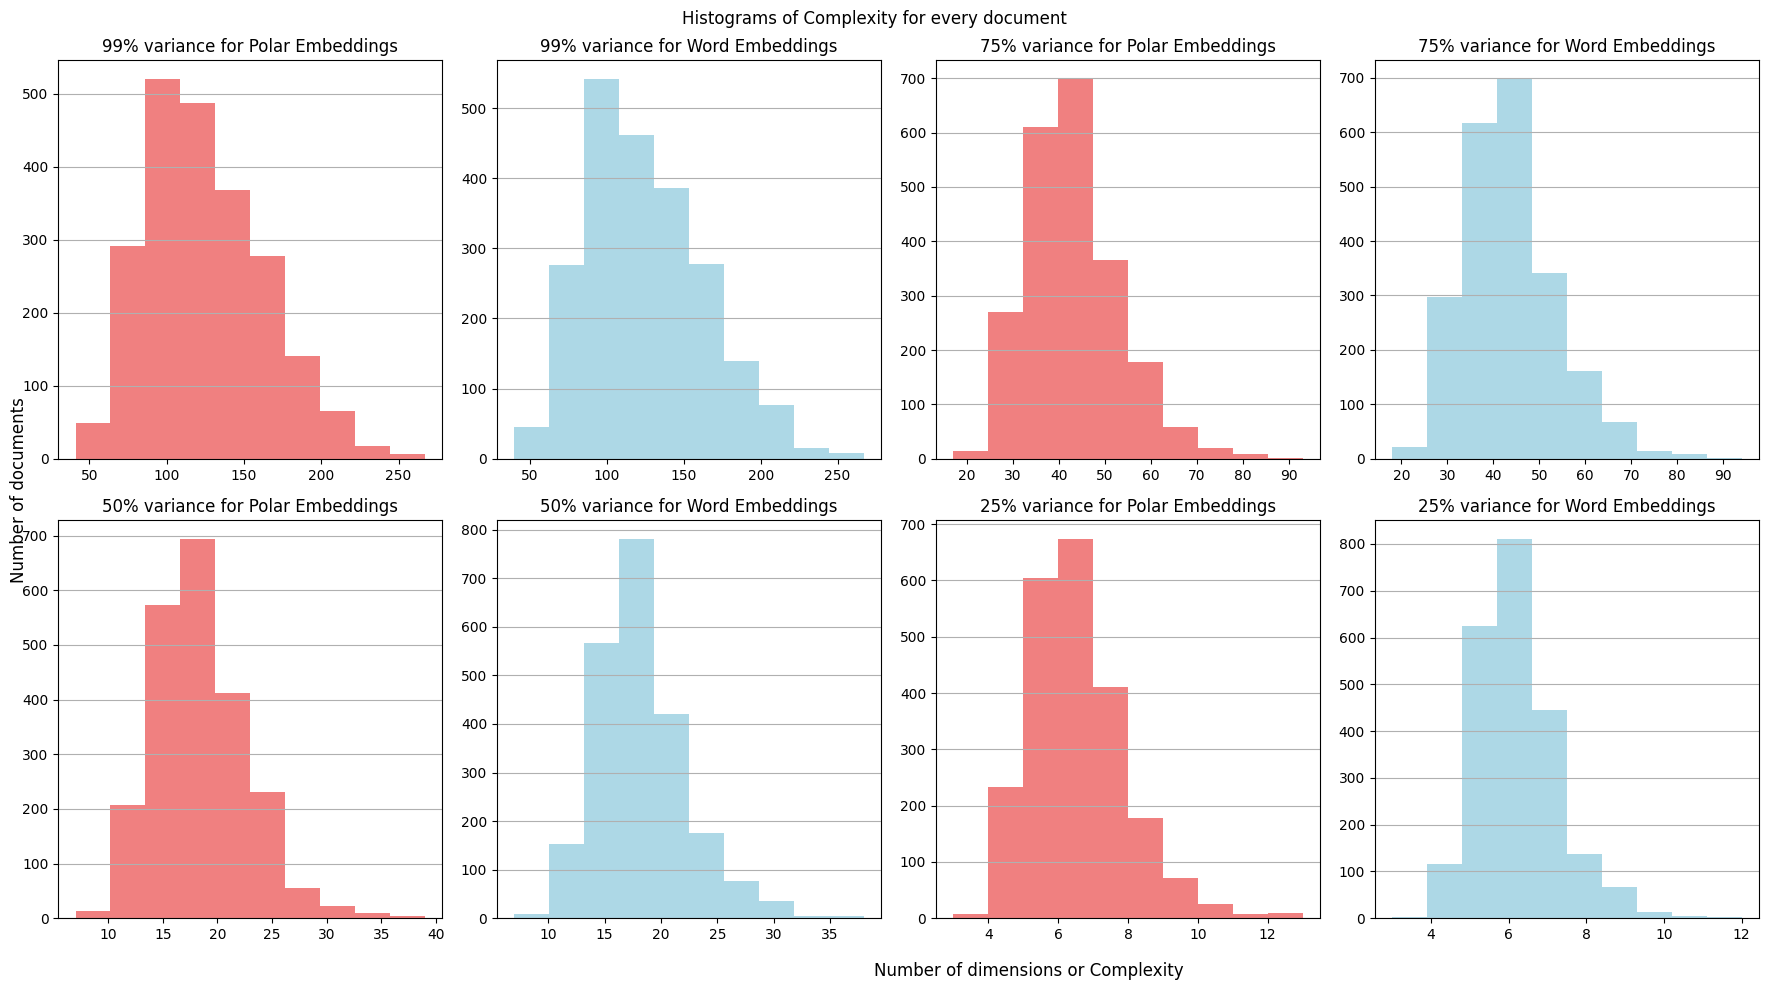

In [15]:
histogram_documents_dimensions(bbc_news_dataset)

It is observed that smaller variance percentage value results in narrower distribution of complexity, and as the variance grows distribution is expanded.

Plot Scatter plot overview of the complexity in all variances and embeddings. Note that the vertical line represents the median of the set

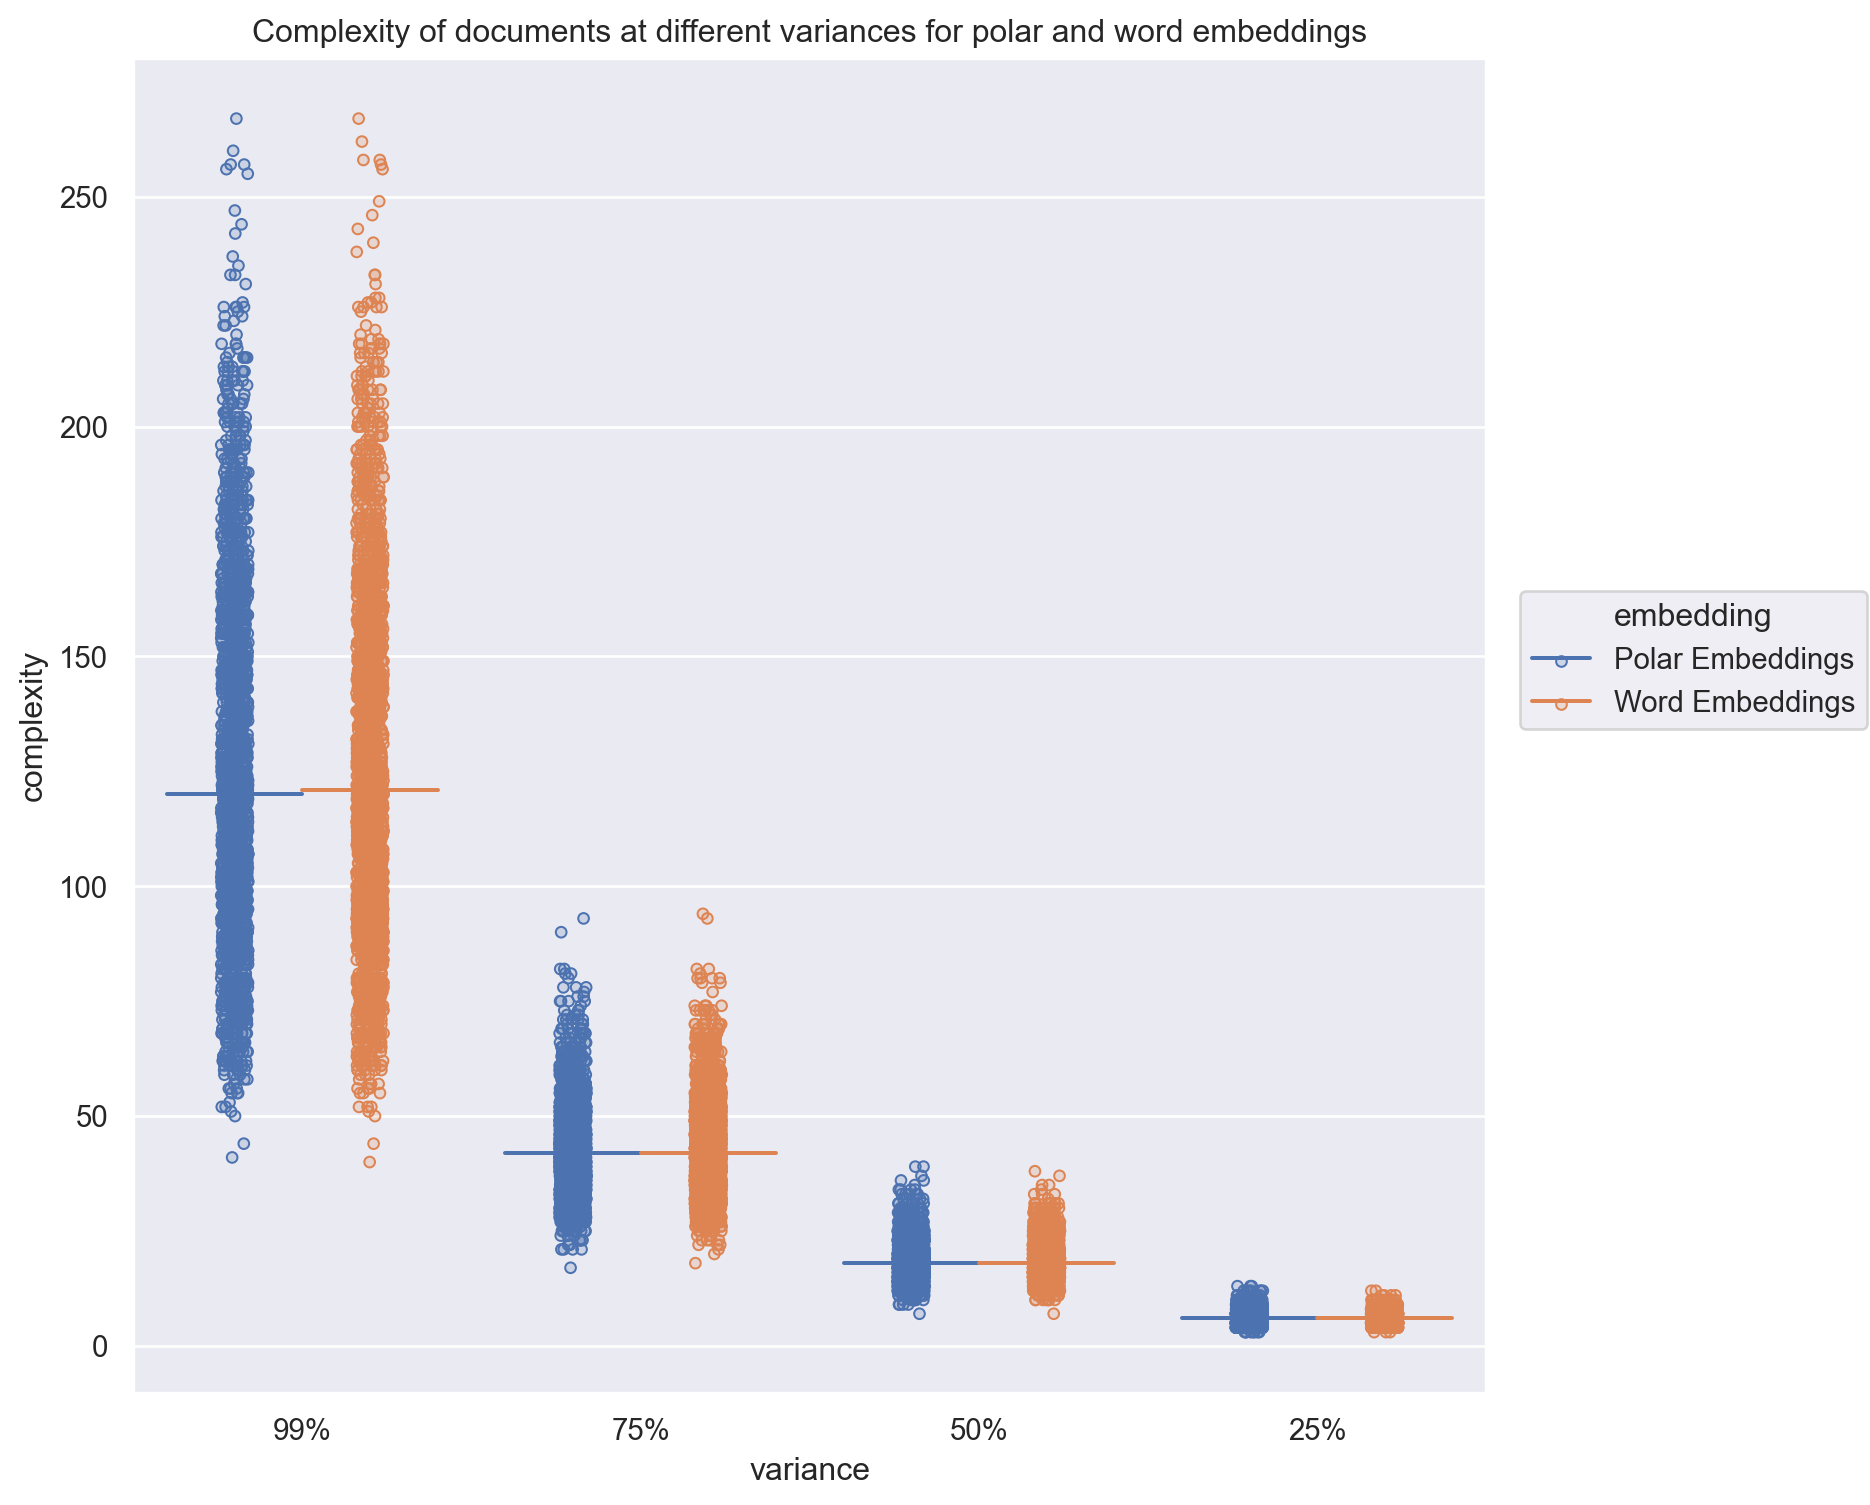

In [86]:
plot_documents_complexity(dataset=bbc_news_dataset, 
                          title='Complexity of documents at different variances for polar and word embeddings', 
                          col_names_suffix='')

It is observed that polar and word embeddings have almost identical distributions and medians. And complexity increases as variance increases.

Plot correlation heatmap between different document complexities and lenght of the documents

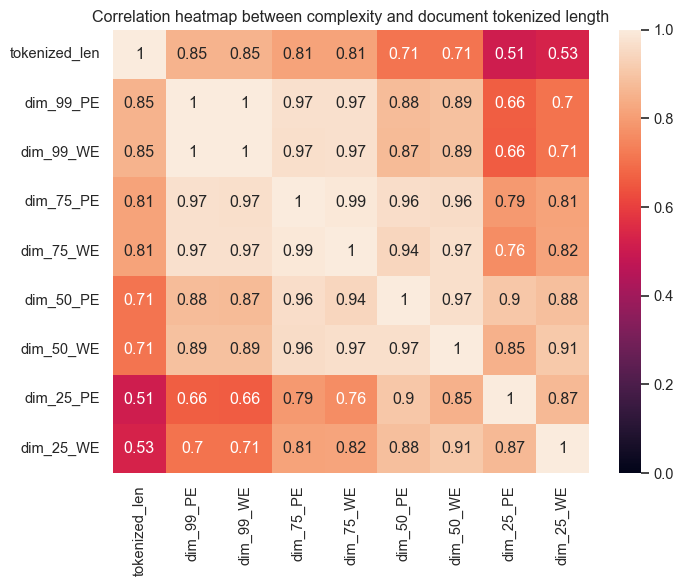

In [89]:
plot_correlation_heatmap(dataset=bbc_news_dataset,
                         column_list=['tokenized_len'] + [f'dim_{v}_{e}' for v in  ['99', '75', '50', '25'] for e in ['PE', 'WE']],
                         title='Correlation heatmap between complexity and document tokenized length')

It is noted that correlation is positive and high between lenght of the document and different complexities. As variance percentage values increases, said correlation increases.
It is also positive and high correlation between different document complexities, and betweem embeddings specially at the same variance percentage

## Cuantify dimensions reducing length

Since correlation is positive and large, let's try different aproaches to smooth this correlation. First, get the document lenght mean and reduce lenght of the news cutting documents to force mean as the maximum lenght, in that way correlation will be calculated with documents much more similar in size

In [40]:
median_tokenized_len = int(bbc_news_dataset['tokenized_len'].median())
median_tokenized_len

202

Reduce the documents, if a document is largen than the mean calculated, then take only the first m words, where m is the mean

In [41]:
bbc_news_dataset['content_tokenized_reduced'] = bbc_news_dataset['content_tokenized'].apply(
    lambda x: x if len(x) < median_tokenized_len else x[:median_tokenized_len])

Cuantify complexities again with the modified dataset

In [9]:
# Define corpus
corpus_reduced = list(bbc_news_dataset['content_tokenized_reduced'])

# Create Object
DC_reduced = DimCuantifier(current_model, final_polar_pairs_list)

# Set Corpus to DimCuantifier
DC_reduced.set_corpus(corpus_reduced)

In [ ]:
calculate_documents_dim_polar_and_word_embeddings(dimcuantifier=DC_reduced,
                                                  dataset=bbc_news_dataset,
                                                  variance_values=[0.99, 0.75, 0.5, 0.25])

Plot new results

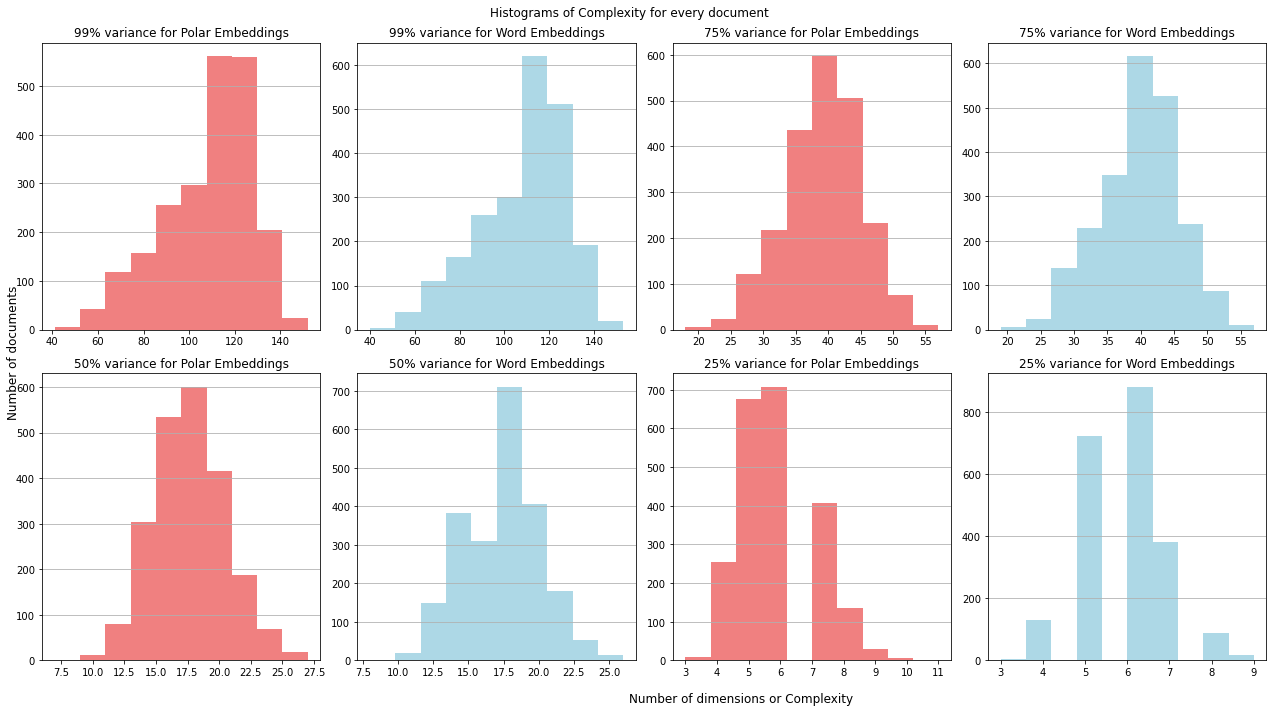

In [6]:
histogram_documents_dimensions(bbc_news_dataset, col_names_suffix='_reduced')

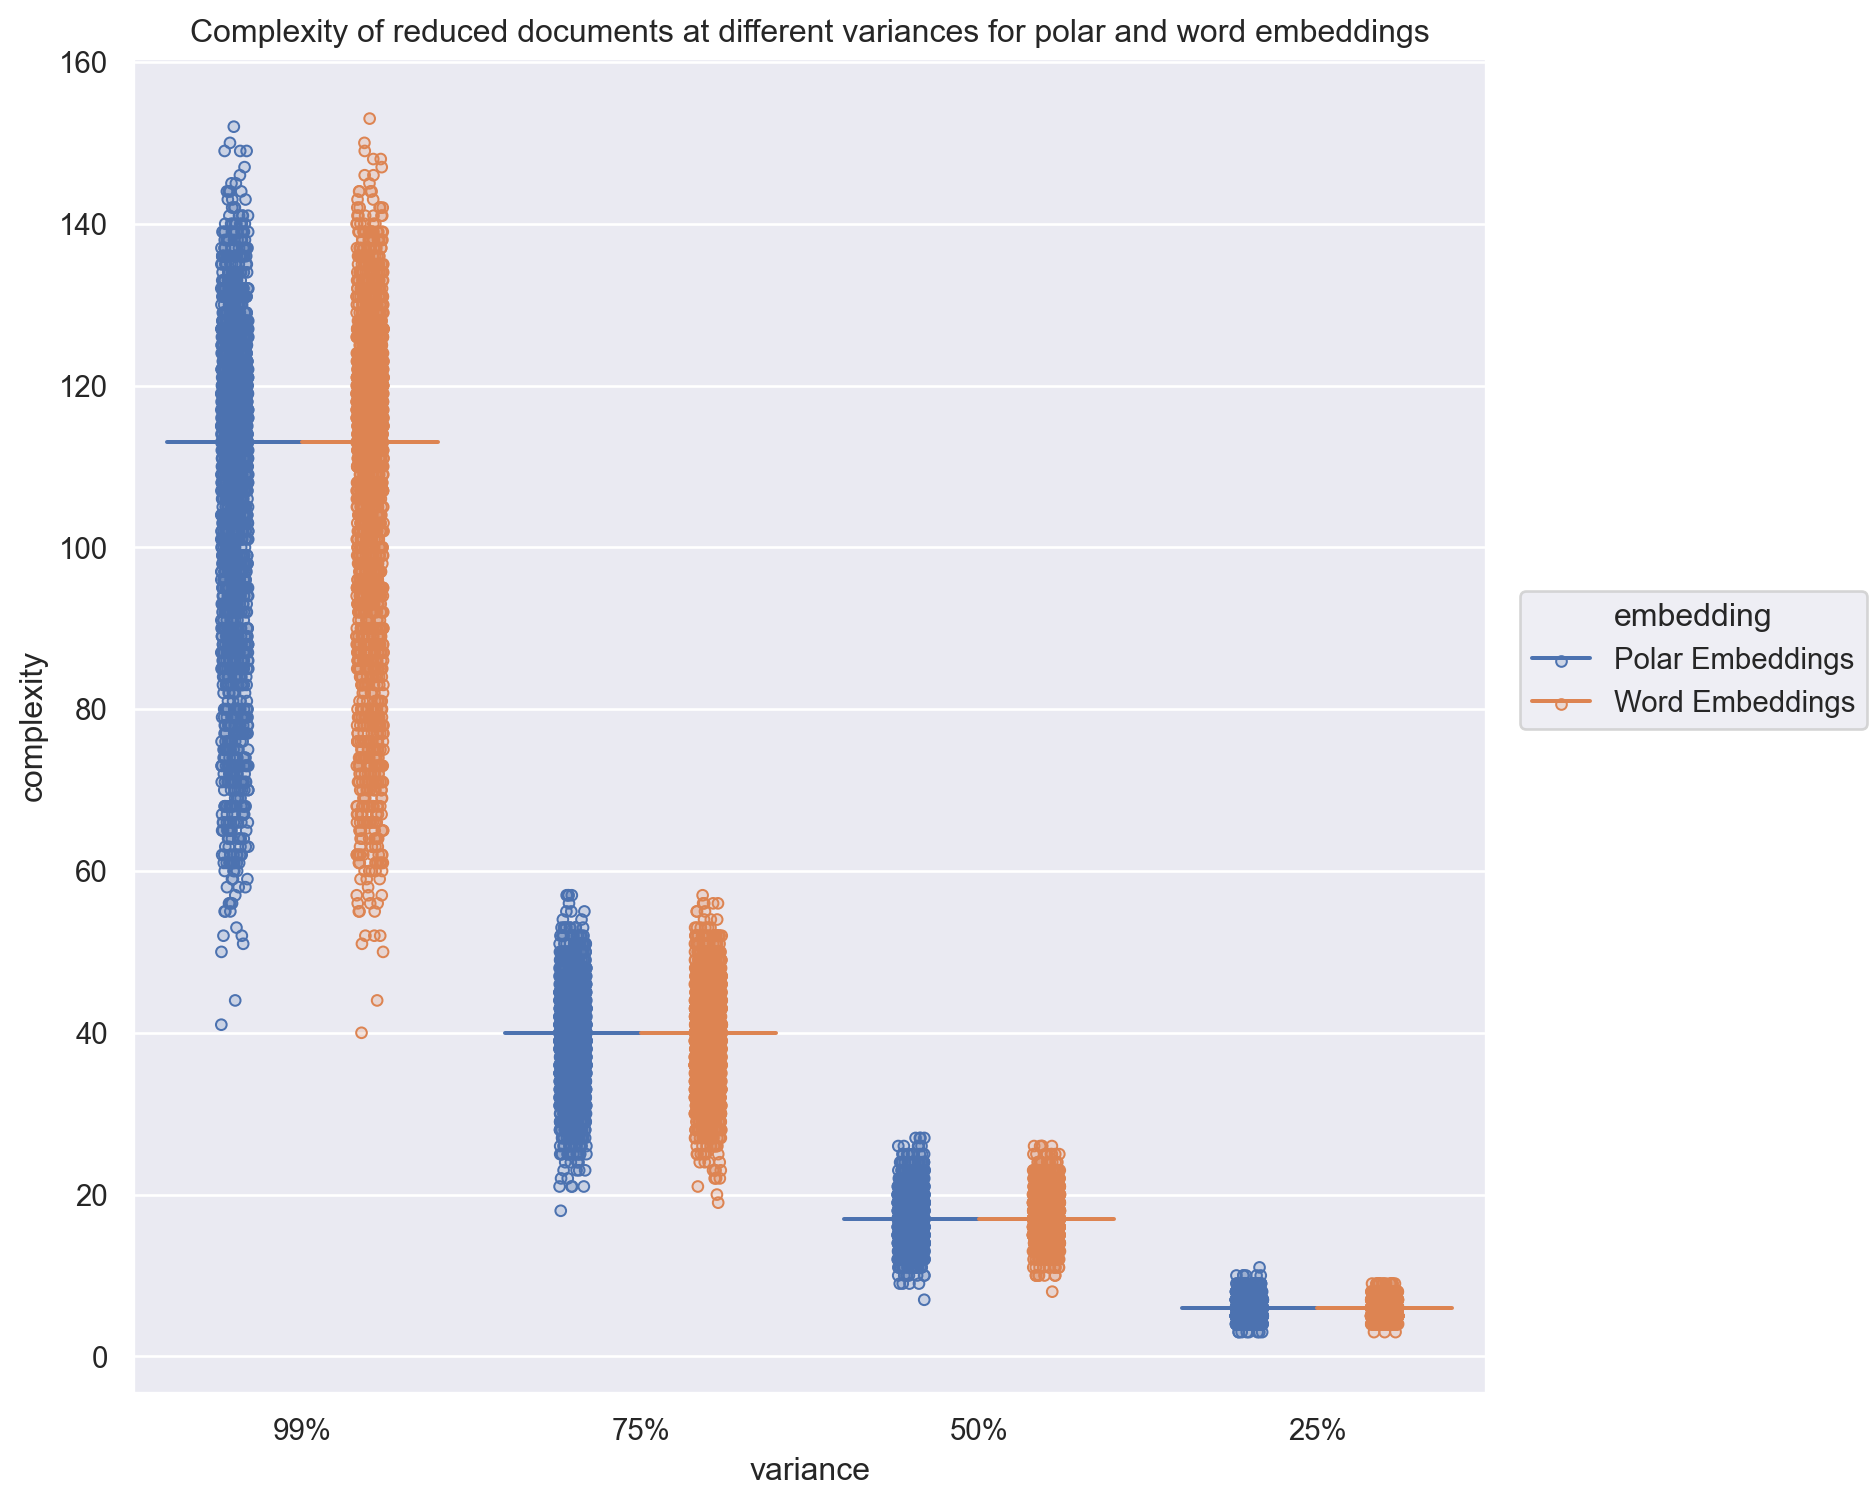

In [85]:
plot_documents_complexity(dataset=bbc_news_dataset, 
                          title='Complexity of reduced documents at different variances for polar and word embeddings', 
                          col_names_suffix='_reduced')

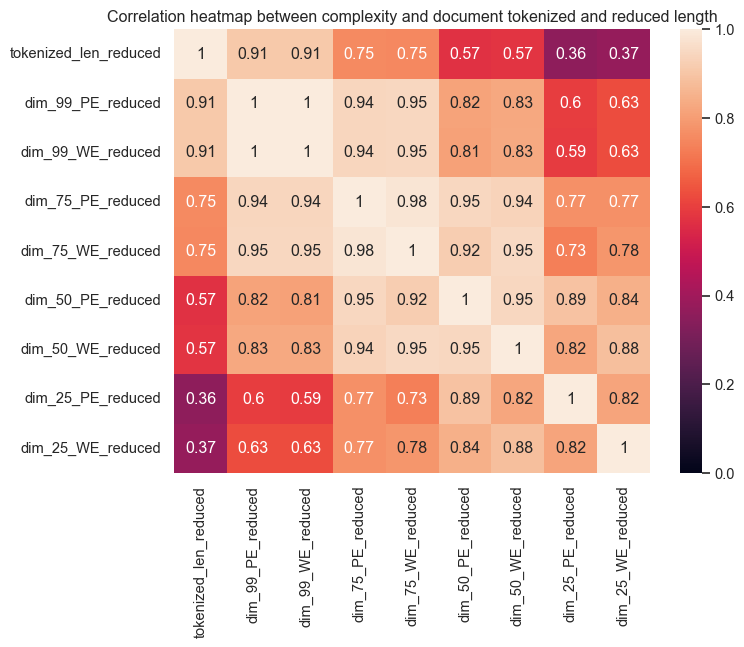

In [90]:
plot_correlation_heatmap(dataset=bbc_news_dataset,
                         column_list=['tokenized_len_reduced'] + [f'dim_{v}_{e}_reduced' for v in  ['99', '75', '50', '25'] for e in ['PE', 'WE']],
                         title='Correlation heatmap between complexity and document tokenized and reduced length')

It can be seen in the new results that distribution of complexities contracted to much more similar results; in histograms distribution highest complexities were cut and in the heatmap map correlation increased for complexity at 99% variance, but it reduced for the other variances

## Cuantify dimensions selecting length similar to mean

Second try will be selecting documents with similar lenght to the median, no more than 10% differente. This will reduce the dataset

In [46]:
# Select documents with a tokenized length around the median
corpus_filtered_selected_around_median = bbc_news_dataset.loc[bbc_news_dataset[
    'tokenized_len'] <= median_tokenized_len + median_tokenized_len * 0.1]
corpus_filtered_selected_around_median = corpus_filtered_selected_around_median.loc[
    bbc_news_dataset['tokenized_len'] >= median_tokenized_len - median_tokenized_len * 0.1]

In [52]:
print(f'{corpus_filtered_selected_around_median.shape[0]} documents are kept in the current dataset')

330 documents are kept in the current dataset


Notice that the dataset is significantly reduced.

Cuantify complexity to selected documents in original tokenized lenght

In [15]:
# Define corpus
corpus_selected = list(corpus_filtered_selected_around_median['content_tokenized'])

# Create Object
DC_selected = DimCuantifier(current_model, final_polar_pairs_list)

# Set Corpus to DimCuantifier
DC_selected.set_corpus(corpus_selected)

In [ ]:
calculate_documents_dim_polar_and_word_embeddings(dimcuantifier=DC_selected,
                                                  dataset=corpus_filtered_selected_around_median,
                                                  variance_values=[0.99, 0.75, 0.5, 0.25])

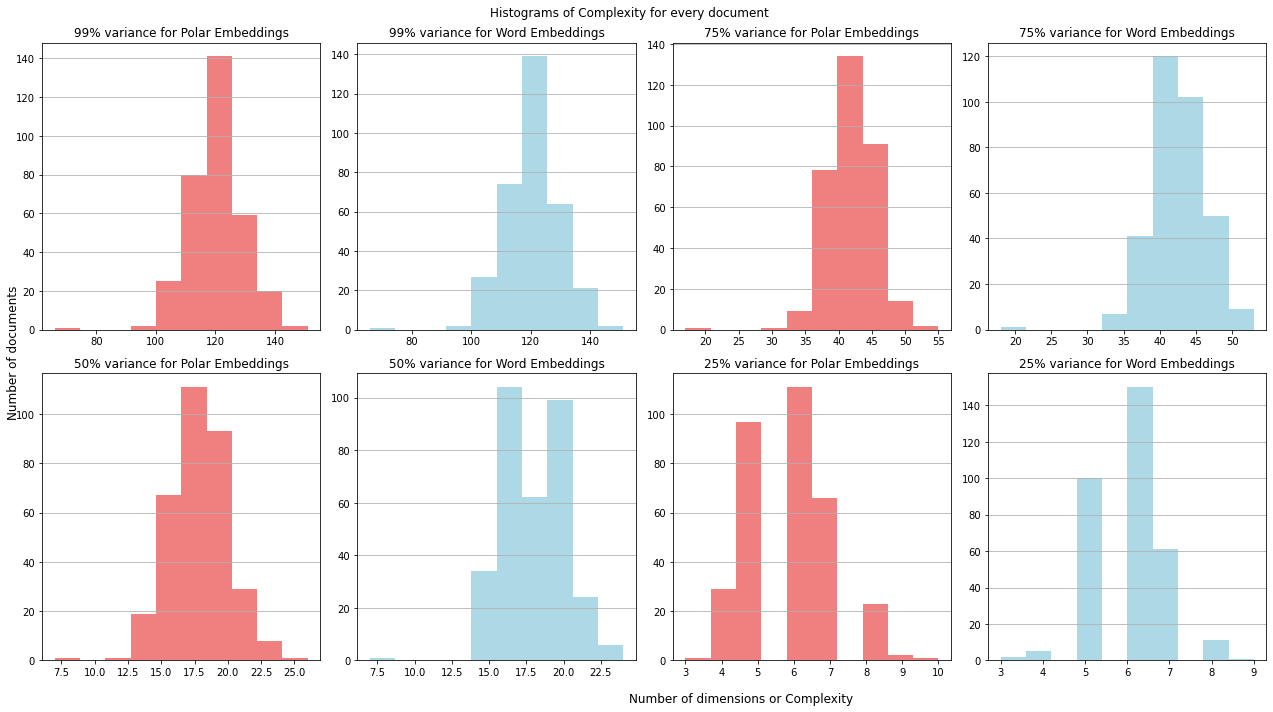

In [161]:
histogram_documents_dimensions(corpus_filtered_selected_around_median, col_names_suffix='_selected')

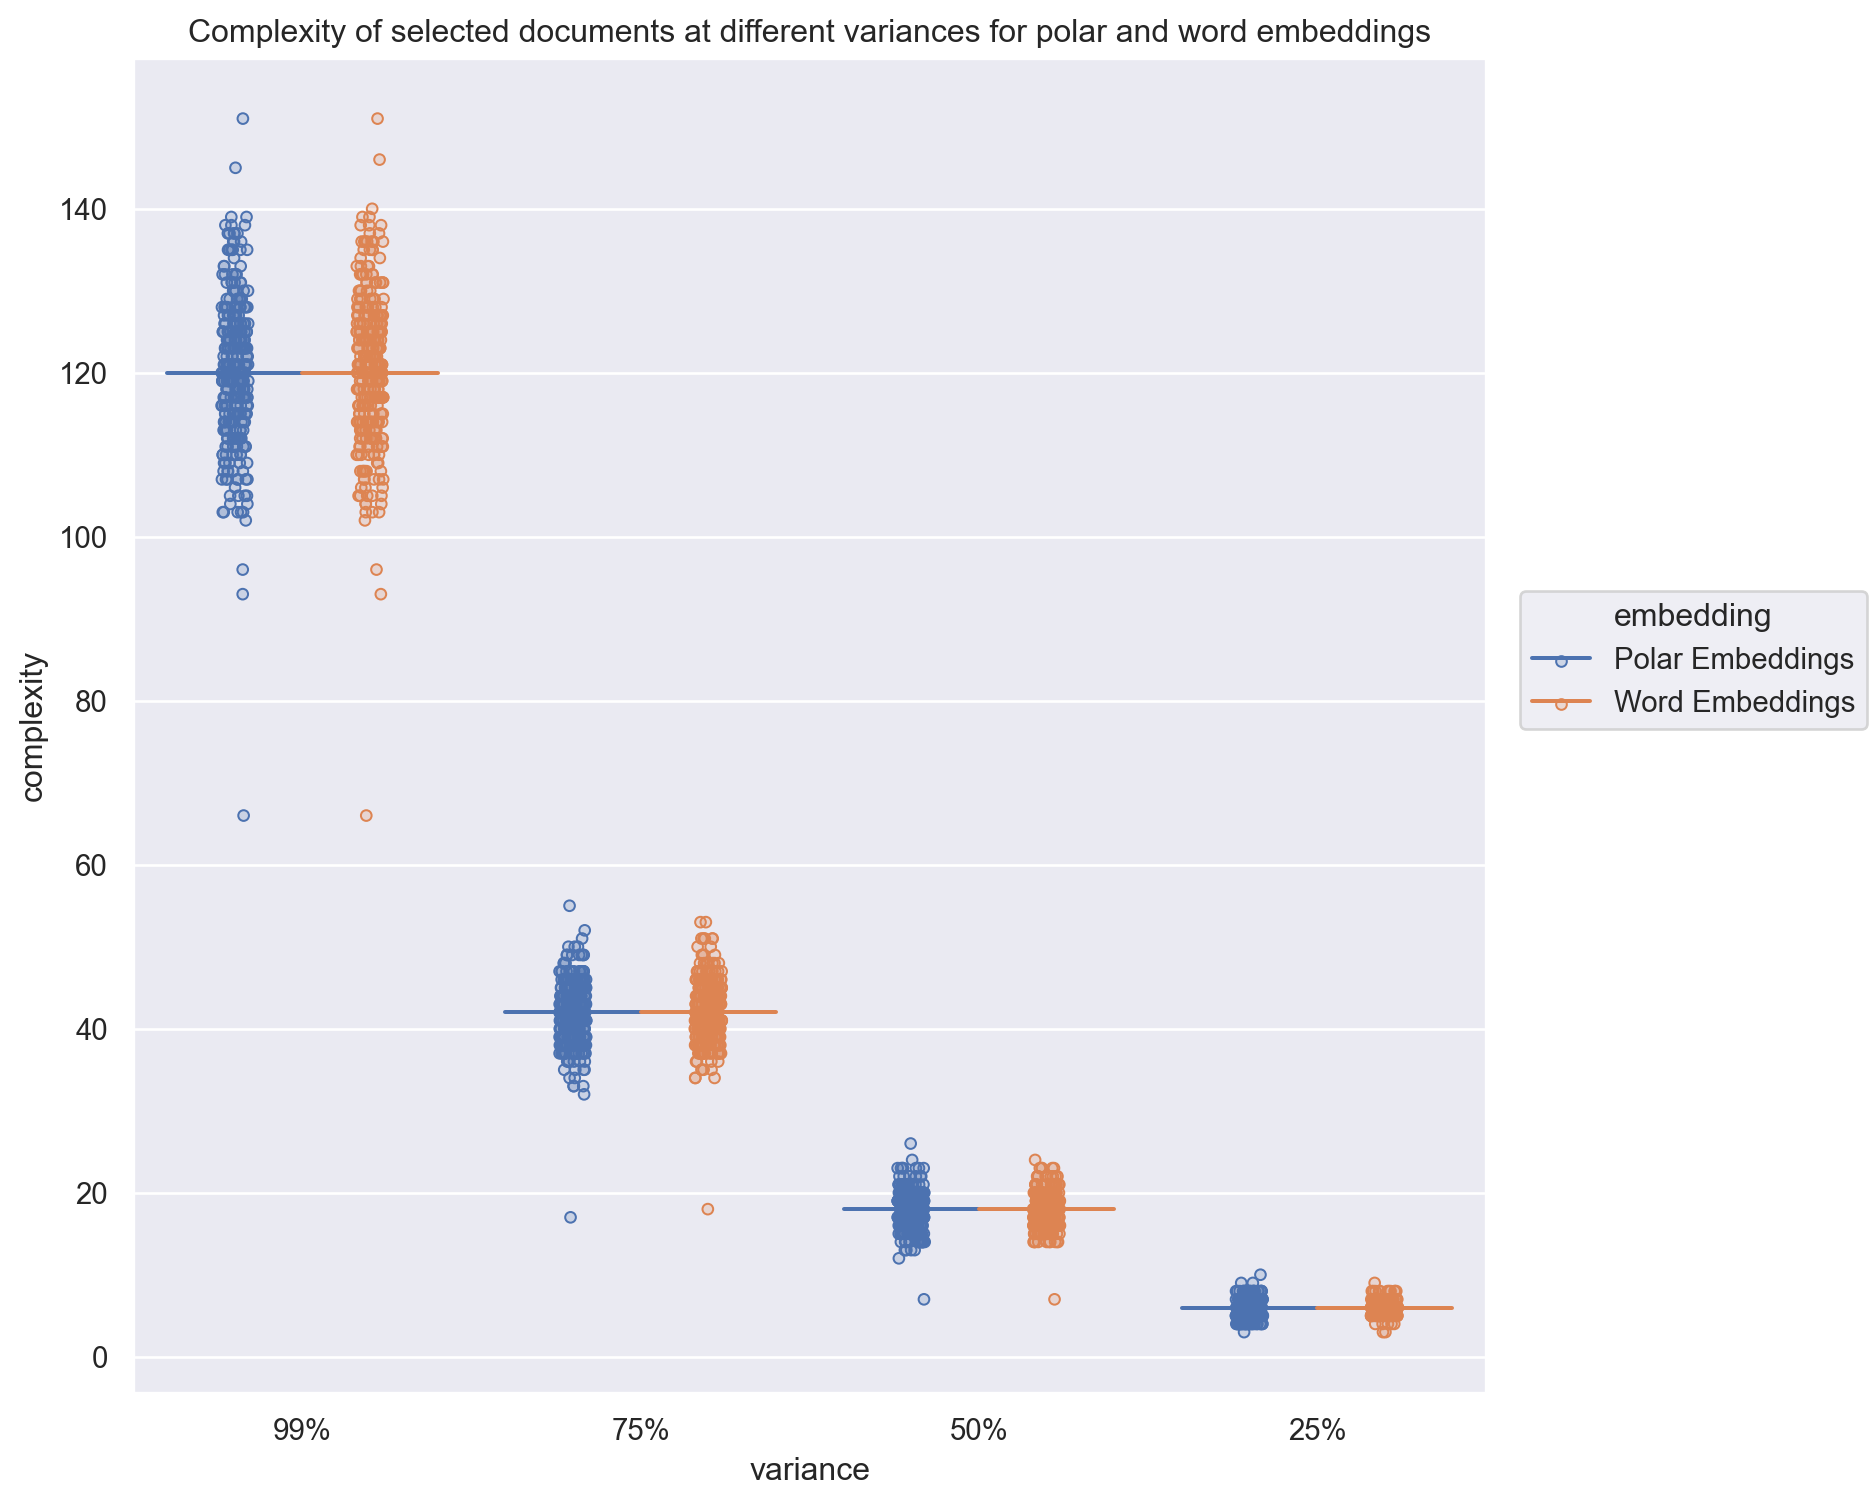

In [84]:
plot_documents_complexity(dataset=corpus_filtered_selected_around_median, 
                          title='Complexity of selected documents at different variances for polar and word embeddings', 
                          col_names_suffix='_selected')

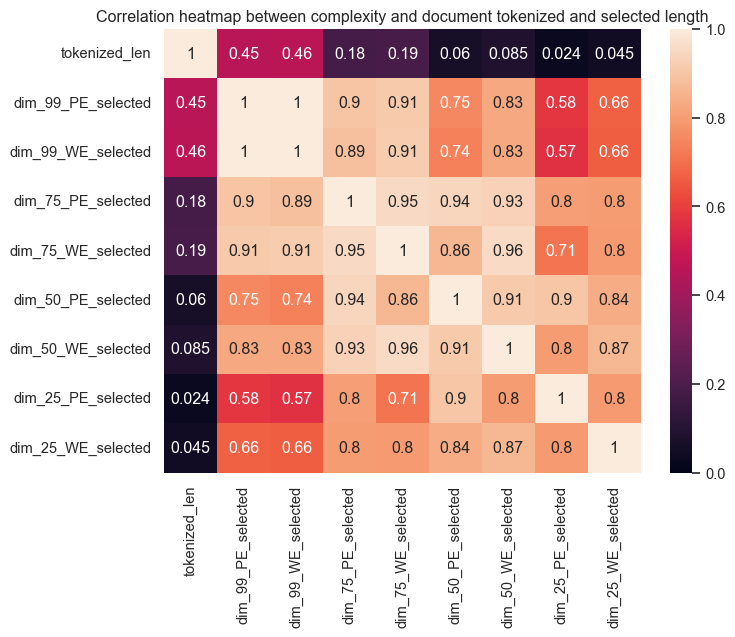

In [91]:
plot_correlation_heatmap(dataset=corpus_filtered_selected_around_median,
                         column_list=['tokenized_len'] + [f'dim_{v}_{e}_selected' for v in  ['99', '75', '50', '25'] for e in ['PE', 'WE']],
                         title='Correlation heatmap between complexity and document tokenized and selected length')

It is noticeable that distributions contracted and correlations significantly decreased, but 99% variation is still high

## Cuantify dimensions selecting length similar to mean and reducing lenght

Combine both methods: reduced documents and select similar length around the mean

In [163]:
# Filter from reduced length

corpus_filtered_reduced_and_selected_around_median = bbc_news_dataset.loc[
    bbc_news_dataset['tokenized_len_reduced'] <= median_tokenized_len + median_tokenized_len * 0.1]
corpus_filtered_reduced_and_selected_around_median = corpus_filtered_reduced_and_selected_around_median.loc[
    bbc_news_dataset['tokenized_len_reduced'] >= median_tokenized_len - median_tokenized_len * 0.1]

In [9]:
print(f'{corpus_filtered_reduced_and_selected_around_median.shape[0]} documents are kept in the current dataset')

1279 documents are kept in the current dataset


Cuantify complexity of current documents reduced and selected and then plot results

In [38]:
# Define corpus
corpus_selected_and_reduced = list(corpus_filtered_reduced_and_selected_around_median['content_tokenized_reduced'])

# Create Object
DC_selected_and_reduced = DimCuantifier(current_model, final_polar_pairs_list)

# Set Corpus to DimCuantifier
DC_selected_and_reduced.set_corpus(corpus_selected_and_reduced)

In [ ]:
calculate_documents_dim_polar_and_word_embeddings(dimcuantifier=DC_selected_and_reduced,
                                                  dataset=corpus_filtered_reduced_and_selected_around_median,
                                                  variance_values=[0.99, 0.75, 0.5, 0.25])

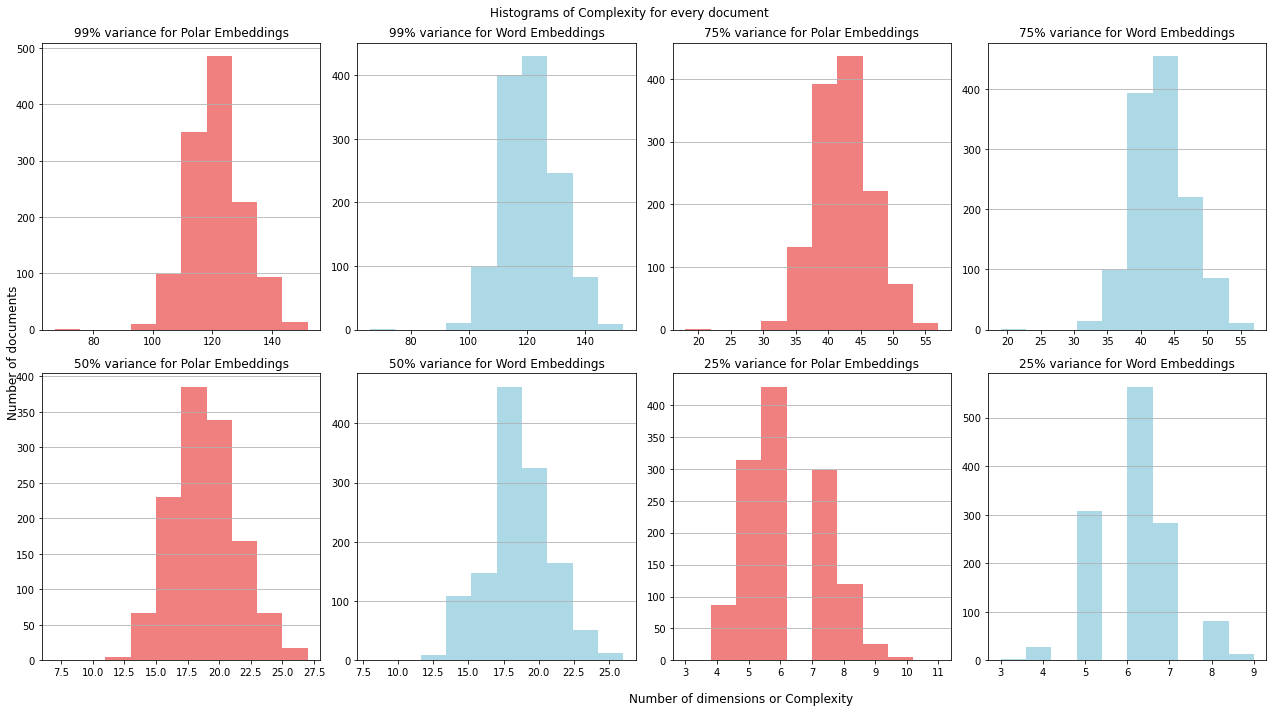

In [162]:
histogram_documents_dimensions(corpus_filtered_reduced_and_selected_around_median, col_names_suffix='_selected_reduced')

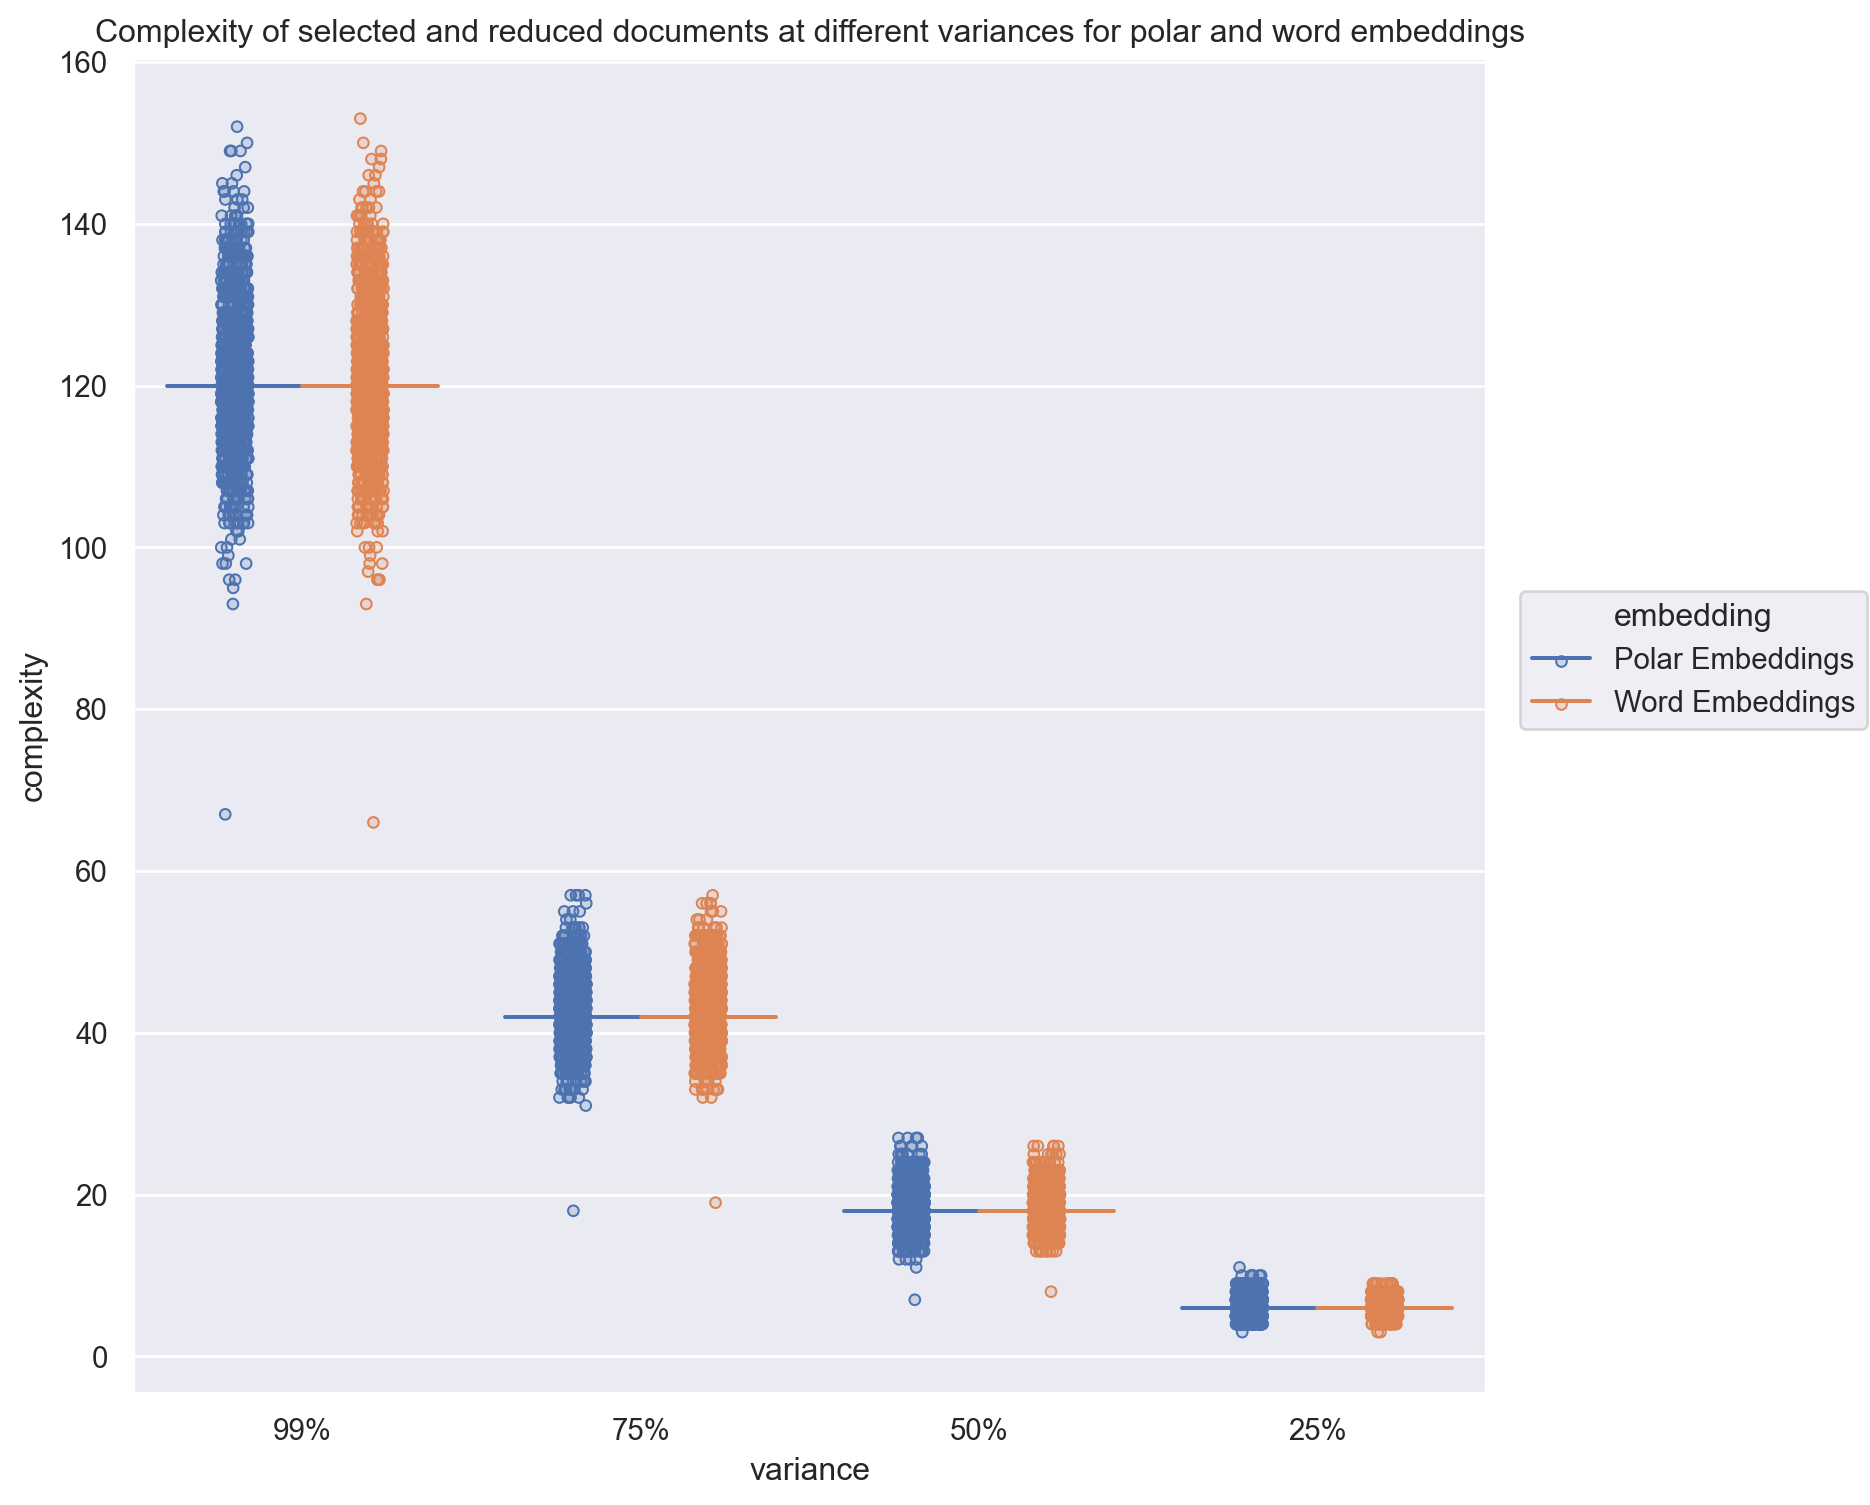

In [83]:
plot_documents_complexity(dataset=corpus_filtered_reduced_and_selected_around_median, 
                          title='Complexity of selected and reduced documents at different variances for polar and word embeddings', 
                          col_names_suffix='_selected_reduced')

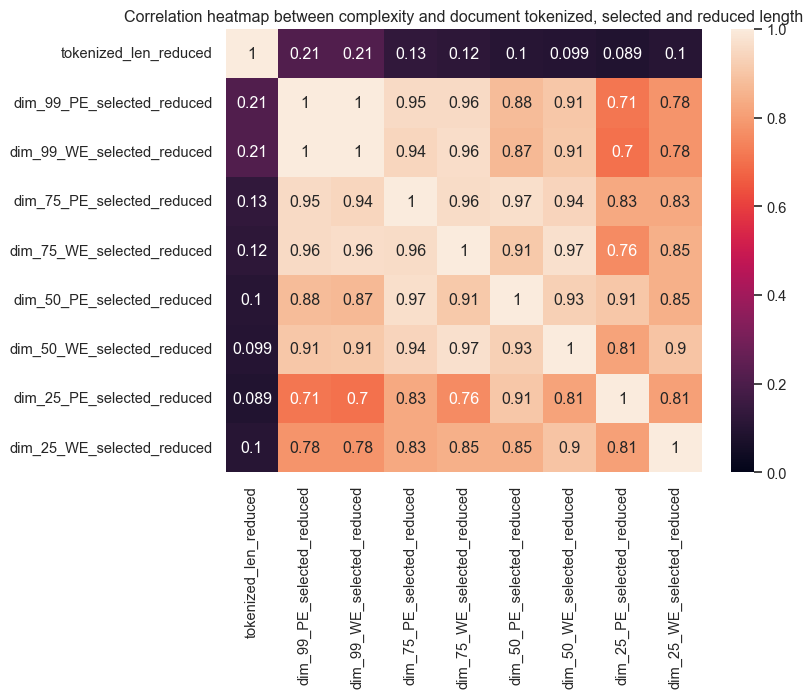

In [92]:
plot_correlation_heatmap(dataset=corpus_filtered_reduced_and_selected_around_median,
                         column_list=['tokenized_len_reduced'] + [f'dim_{v}_{e}_selected_reduced' for v in  ['99', '75', '50', '25'] for e in ['PE', 'WE']],
                         title='Correlation heatmap between complexity and document tokenized, selected and reduced length')

Correlation decreased for 99% variation complexity

# Conclusion



- In order to minimize high correlation between document complexity and its lenght is better to compare similar lenghts, that can be done selecting similar lenght documents or cutting larger documents

- There is not much difference between cuantifying complexity for polar or word embeddings

- Higher variance percentage increase dispersion of values, therefore, to compare document complexities is better to use high percentage variance values